## Simplified Problem with binary classification by keeping 2 most frequent classes
## Deep Learning training with LSTM and an extended FastText word embedding
We test here the combination of:
* an embedding layer which is initialized with a pretrained fasttext word embedding extended with custom embedding model
* a LTSM layer to capture word sequence representation
* a dense layer to learn classification

We leverage the pre-trained fasttext word embedding model gracefully supplied by Facebook company at [https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md)

This general purpose word embedding model is extended with custom model generated by [fasttext_embedding_extension_builder.ipynb](fasttext_embedding_extension_builder.ipynb) script

In [62]:
import numpy as np
import pandas as pd
import sys
sys.path.append('..')
from utils import vizu
from utils import serializer

embeddings_index = {}

In [98]:
from sklearn.model_selection import train_test_split

XTrain = pd.read_csv('../../data/staging_data/mispelling_fixed_clean_input_train.csv', sep=',')
YTrain = pd.read_csv('../../data/POSOS/label.csv', sep=';')


### keep only the 2 most frequent classes (28 and 31)

In [99]:
XYTrain = XTrain.merge(YTrain, on="ID")
XYTrain = XYTrain[XYTrain.intention.isin([28,31])]
XYTrain["intention"] = XYTrain.intention.apply(lambda x: 1 if x == 28 else 0)
XTrain = XYTrain[['ID', 'question']]
YTrain = XYTrain[['ID', 'intention']]

XTrain, XTest, YTrain, YTest = train_test_split(XTrain, YTrain, test_size=0.15, random_state=42)

,ID,intention
7115,7115,0
747,747,1
1487,1487,1
458,458,0
76,76,1


###  <b>Build neural network with LSTM and FastText embedding<b>

In [100]:
# hyper-parameters
#num_classes = 2
vocabulary_size = 10000
sequence_length = 30
embedding_out_dims = 300
dropout_ratio = 0.10
num_epochs = 100
hidden_dims = 100
patience = 20

In [101]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(XTrain['question'])

sequences = tokenizer.texts_to_sequences(XTrain['question'])
XEncodedTrain = pad_sequences(sequences, maxlen=sequence_length, truncating='pre')

In [70]:
# load the French fasttext model
import os, re, csv, math, codecs
from tqdm import tqdm

if len(embeddings_index) == 0:
    
    f = codecs.open('../../pretrained_models/fasttext/wiki.fr.vec', encoding='utf-8')
    for line in tqdm(f):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

1152466it [02:35, 7411.22it/s]


In [71]:
# complete the embedding mode with the custom one built by the script additional_fasttext_embedding_builder.ipynb
customEmbedding = serializer.loadEmbeddingVector('../../pretrained_models/fasttext_embedding_extension.txt')

for k,v in customEmbedding.items():
    embeddings_index[k] = v    

In [102]:
nb_words = min(vocabulary_size, len(tokenizer.word_index))

embedding_matrix = np.zeros((nb_words+1, embedding_out_dims))

for word, i in tokenizer.word_index.items():
    if i >= nb_words:
        continue
                
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        raise Exception("unknown word=" + word)

In [103]:
import tensorflow as tf
import keras
from keras.layers import CuDNNLSTM
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional
#config = tf.ConfigProto(device_count={"CPU": 32})

# configure tensorflow
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7, allow_growth = True)
config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=True)
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

# build neural network
model_lstm = Sequential()

# dimension reduction layer
model_lstm.add(
    Embedding(
        len(tokenizer.word_index)+1,
        embedding_out_dims,
        weights=[embedding_matrix],
        input_length=sequence_length,
        trainable=False))

# recurrent network layer
#model_lstm.add(Bidirectional(CuDNNLSTM(embedding_out_dims)))
model_lstm.add(CuDNNLSTM(embedding_out_dims))

# classification hidden layer
model_lstm.add(Dense(hidden_dims, kernel_initializer='normal', activation="relu"))

# random node inactivation
model_lstm.add(Dropout(dropout_ratio))

# normalization layer
model_lstm.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 30, 300)           1225800   
_________________________________________________________________
cu_dnnlstm_11 (CuDNNLSTM)    (None, 300)               722400    
_________________________________________________________________
dense_21 (Dense)             (None, 100)               30100     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 101       
Total params: 1,978,401
Trainable params: 752,601
Non-trainable params: 1,225,800
_________________________________________________________________


import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from keras.utils.vis_utils import plot_model
plot_model(model_lstm, to_file='c:/Users/I051796/Projects/CES/report/model.png', show_shapes=True)

#pd.DataFrame(XEncodedTrain).to_csv('c:/Users/I051796/Projects/CES/notebooks/XEncodedTrain.txt', index=False, header=False)
XEncodedTrain = pd.read_csv('c:/Users/I051796/Projects/CES/notebooks/XEncodedTrain.txt', header=None)
XEncodedTrain = XEncodedTrain.values
XEncodedTrain.shape

### Train the network

In [106]:
YOneHotEncodedTrain = YTrain['intention']

In [107]:
# generate the tensorflow board
call_back_board = keras.callbacks.TensorBoard(
    log_dir='c:/git/CES/logs',
    histogram_freq=0,
    batch_size=10,
    write_graph=True,
    write_grads=True,
    write_images=True,
    embeddings_freq=0,
    embeddings_layer_names=None,
    embeddings_metadata=None,
    embeddings_data=None)

# stop criterion to avoid overfitting
call_back_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=patience,
    verbose=0,
    mode='auto',
    baseline=None)

# learn !
model_lstm.fit(
    XEncodedTrain,
    np.array(YOneHotEncodedTrain),
    validation_split=0.10,
    epochs=num_epochs,
    verbose=2,
    callbacks = [call_back_early_stopping, call_back_board])
pass

Train on 1805 samples, validate on 201 samples
Epoch 1/100
 - 2s - loss: 0.5117 - acc: 0.7657 - val_loss: 0.4642 - val_acc: 0.8209
Epoch 2/100
 - 1s - loss: 0.3440 - acc: 0.8698 - val_loss: 0.2730 - val_acc: 0.9005
Epoch 3/100
 - 1s - loss: 0.2235 - acc: 0.9191 - val_loss: 0.1778 - val_acc: 0.9453
Epoch 4/100
 - 1s - loss: 0.1731 - acc: 0.9363 - val_loss: 0.2106 - val_acc: 0.9254
Epoch 5/100
 - 1s - loss: 0.1598 - acc: 0.9402 - val_loss: 0.2178 - val_acc: 0.9154
Epoch 6/100
 - 1s - loss: 0.1143 - acc: 0.9612 - val_loss: 0.1560 - val_acc: 0.9602
Epoch 7/100
 - 1s - loss: 0.0951 - acc: 0.9623 - val_loss: 0.1401 - val_acc: 0.9701
Epoch 8/100
 - 1s - loss: 0.0854 - acc: 0.9695 - val_loss: 0.1568 - val_acc: 0.9502
Epoch 9/100
 - 1s - loss: 0.0618 - acc: 0.9795 - val_loss: 0.1335 - val_acc: 0.9751
Epoch 10/100
 - 1s - loss: 0.0375 - acc: 0.9850 - val_loss: 0.1798 - val_acc: 0.9751
Epoch 11/100
 - 1s - loss: 0.0391 - acc: 0.9878 - val_loss: 0.1523 - val_acc: 0.9602
Epoch 12/100
 - 1s - loss: 

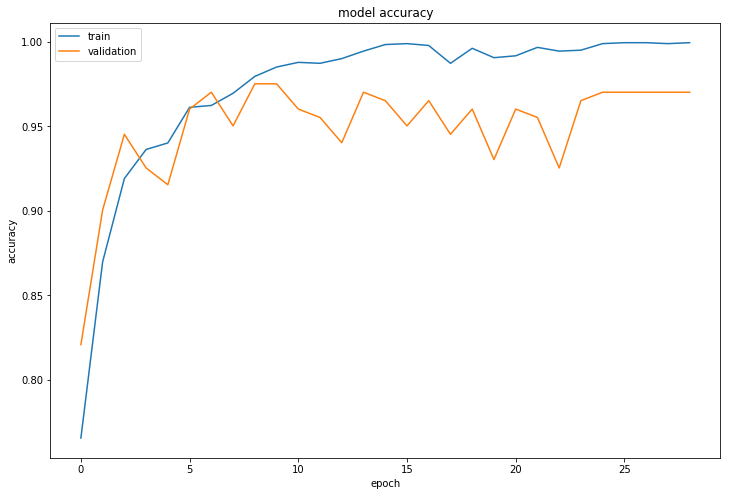

In [108]:
%matplotlib inline
vizu.plot_keras_model_learning_curve(model_lstm.history)

             precision    recall  f1-score   support

          0       0.88      0.76      0.82        89
          1       0.92      0.97      0.94       266

avg / total       0.91      0.92      0.91       355

Confusion matrix, without normalization
[[ 68  21]
 [  9 257]]


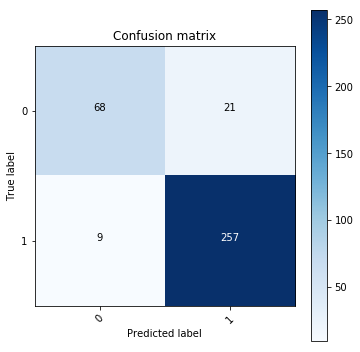

In [111]:
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

testSequences = tokenizer.texts_to_sequences(XTest['question'])
XEncodedTest = pad_sequences(testSequences, maxlen=sequence_length)
    
YTrue = YTest['intention']
YPredicted = model_lstm.predict_classes(XEncodedTest)
#YPredicted =list(map(lambda x : getHighProbaLabel(x), YProba))

cnf_matrix = confusion_matrix(YTrue, YPredicted)

print(sklearn.metrics.classification_report(YTrue, YPredicted))
 
plt.figure(figsize=(5,5))

vizu.plot_confusion_matrix(cnf_matrix, normalize=False, classes = np.unique(YTrain['intention']))

plt.show()
